# IMU sandbox

Notebook to play with IMU data. 
Start with a dataset with no rotation but just translation

In [1]:
# imports
import matplotlib as plt
plt.rcParams['animation.ffmpeg_path'] = '/camp/apps/eb/software/FFmpeg/4.1-foss-2018b/bin/ffmpeg'
%matplotlib inline
import os
import cv2
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [2]:
# find the data
data_root = Path('/camp/lab/znamenskiyp/data/instruments/raw_data/projects/blota_onix_pilote/')
data_root = data_root / 'tracking'
save_root = Path('/camp/lab/znamenskiyp/home/shared/projects/blota_onix_calibration/')

In [3]:
# list of folders where there is no mvt
stable_folders = ['hs_at_0.300.0',
                  'hs_at_300.0.0',
                  'hs_at_0.0.0',
                  'hs_at_0.0.200']

In [4]:
# load lighthouse data
light_data = dict()
for folder in stable_folders:
    fnames = os.listdir(data_root / folder)
    light_data[folder] = dict()
    for lindex in (1, 2):
        dat = [n for n in fnames if n.startswith('lighthouse_matrix%d'%lindex)]
        assert len(dat) == 1
        dat = dat[0]
        data = np.fromfile(data_root / folder / dat, dtype='double')
        data = data.reshape([-1, 3])
        light_data[folder]['pd%d'%lindex] = data


In [5]:
# make a summary dataframe

summary = []
for name, datadict in light_data.items():
    for pdname, data in datadict.items():
        line = dict(name=name)
        line['photodiode'] = pdname
        line['uid'] = '{0}_{1}'.format(name, pdname)
        
        line['median'] = np.nanmedian(data, axis=0)
        line['std'] = np.nanmedian(data, axis=0)
        line['n'] = data.shape[0]
        summary.append(line)
summary = pd.DataFrame(summary)
summary = summary[summary.photodiode=='pd2']
summary.set_index('name', inplace=True, drop=False)


/camp/home/blota/.conda/envs/opencv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [6]:
# Set a new coordinate system with the center of the arena as the origin

origin = summary.loc['hs_at_0.0.0', 'median']
summary['centered'] = summary['median'].map(lambda x: x - origin)
# x is bl to br
vecX = summary.loc['hs_at_300.0.0', 'centered']
vecY = summary.loc['hs_at_0.300.0', 'centered']
vecZ = np.cross(vecX, vecY)

In [7]:
# make a change of basis matrix
A_new2old = np.vstack([vecX, vecY, vecZ]).T
A_new2old[:,0] /= 300
A_new2old[:,1] /= 300
# the norm of the crossproduct is ||a||.||b||.sin(angle between a and b)
# for me we should have 90 degrees, so sin = 1. 
A_new2old[:,2] /= (300 * np.linalg.norm(vecY))
print('New to old transformation matrix')
print(A_new2old)
A_old2new = np.matrix(np.linalg.inv(A_new2old))

print('\nOld to new transformation matrix')
print(A_old2new)

summary['rotated'] = summary['centered'].map(lambda x: np.array(np.matmul(A_old2new, x))[0])

New to old transformation matrix
[[-4.58423943e-06  1.70453126e-03  4.18258260e-05]
 [ 1.70220760e-03 -2.46227804e-05 -4.70611898e-06]
 [-4.82091134e-06  4.19697199e-05 -1.70144823e-03]]

Old to new transformation matrix
[[   8.5214503   587.49135141   -1.41549267]
 [ 586.34016307    1.61989012   14.4092179 ]
 [  14.43914123   -1.62464972 -587.37515987]]


In [8]:
# now that I have the transform make a function that can load and transform
def load_ts4231v1(folder, pd_index):
    """Load data for one vive photodiode"""
    out = dict()
    fnames = os.listdir(data_root / folder)
    dat = [n for n in fnames if n.startswith('lighthouse_matrix%d'%pd_index)]
    assert len(dat) == 1
    dat = dat[0]
    data = np.fromfile(data_root / folder / dat, dtype='double')
    data = data.reshape([-1, 3])
    ln_centered = data - origin
    ln_rotated = np.array(np.matmul(A_old2new, ln_centered.T)).T
    out['pd_raw'] = data
    out['pd_in_arena'] = ln_rotated
    fn = [f for f in fnames if f.startswith('lighthouse%d_time'%pd_index)]
    assert len(fn) == 1
    light_df = pd.read_csv(data_root / folder / fn[0])
    for c in light_df.columns:
        out[c] = light_df[c].values
    return out

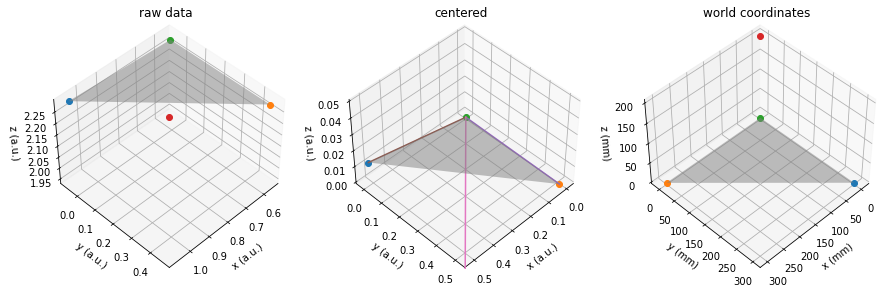

In [9]:
fig = plt.figure(figsize=(15,5), facecolor='white')

axes = [fig.add_subplot(1,3,1+i, projection='3d') for i in range(3)]

for _, d in summary[summary.photodiode=='pd2'].iterrows():
    for iax, what in enumerate(['median', 'centered', 'rotated']):
        axes[iax].plot(*d[what], 'o')

labels = ['raw data', 'centered', 'world coordinates']   
units = ['(a.u.)', '(a.u.)', '(mm)']
for iax, what in enumerate(['median', 'centered', 'rotated']):
    d = [summary.loc['hs_at_%s'%c, what] for c in ['0.0.0', '0.300.0', '300.0.0', '0.0.200']]
    
    if iax == 1:
        axes[iax].plot(*[[0, vecX[i]] for i in range(3)])
        axes[iax].plot(*[[0, vecY[i]] for i in range(3)])
        axes[iax].plot(*[[0, vecZ[i]] for i in range(3)])
        axes[iax].set_zlim([0,0.05])
    x = np.array([[d[0][0], d[1][0]], [d[2][0], d[1][0]]])
    y = np.array([[d[0][1], d[1][1]], [d[2][1], d[1][1]]])
    z = np.array([[d[0][2], d[1][2]], [d[2][2], d[1][2]]])
    
    

    axes[iax].plot_surface(x, y, z, zorder=-10, alpha=0.5, color='grey')
    axes[iax].set(xlabel='x %s'%units[iax], ylabel='y %s'%units[iax], zlabel='z %s'%units[iax])
    axes[iax].view_init(45, 45)
    axes[iax].set_title(labels[iax])
    #axes[iax].set_zlim([0,axes[iax].get_xlim()[1] + z.mean()])
    

In [10]:
print(summary.rotated['hs_at_0.0.200'])

[ -3.63090131  -4.11479035 204.44600538]


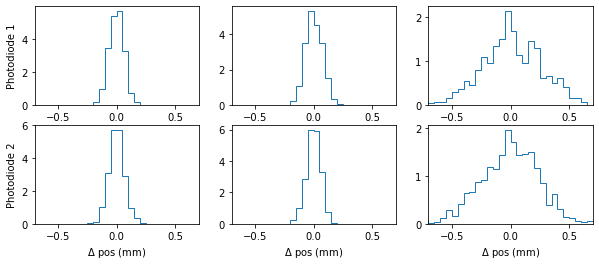

In [11]:
# combine data
combined_pos = {k:[] for k in [0,1]}
for name, data_dict in light_data.items():
    for ipd, (l, data) in enumerate(data_dict.items()):
        cdata = data - origin
        # rotate
        rdata = np.array(np.matmul(A_old2new, cdata.T)).T
        combined_pos[ipd].append(rdata - np.nanmedian(rdata, axis=0))
for k in combined_pos.keys():
    combined_pos[k] = np.vstack(combined_pos[k])

fig, axes = plt.subplots(2, 3)
fig.set_facecolor('white')
fig.set_size_inches([10,4])
for ipd,  data in combined_pos.items():
    for i in range(3):
        axes[ipd, i].hist(data[:,i] - np.nanmedian(data[:,i]), bins=np.arange(-1,1.1,0.05),
                          histtype='step', density=True)
        axes[ipd, i].set_xlim([-0.7,0.7])
        axes[ipd, i].set_xlabel('$\Delta$ pos (mm)')
    axes[ipd,0].set_ylabel('Photodiode %d'%(ipd+1))

        

In [12]:
rms = np.sqrt(1/data.shape[0] * np.sum(np.diff(data, axis=0)**2, axis=0))
rms


array([0.09325033, 0.08481532, 0.33875158])

# IMU data

## Original Frame

The first step is to understand what is the original frame in which the data comes out of the BNO055.

### Acceleration


That's easy, I can just move the headstage and find when, X,Y and Z get a positive acceleration:

![Headstage with axes of acceleration](resources/BNO055_acceleration.png "Acceleration in body frame")

## Orientation

It's a bit more annoying as there are two outputs: quaternion and euler. 

### Euler

This has been reported to be very unstable when the pitch is above 40 degrees. It is easy enough to check anyway, we just have to move the headstage and look at the output like. 
In case it is of interest, I measured it to be that:
![Headstage with axes of Euler angles as read in Bonsai](resources/BNO055_euler.png "Euler angles in body frame")

The Y axis points towards the North and the X axis towards East. So we have a ENU coordinate system.

### Quaternion

This is a bit more annoying as it is not very intuitive. So I'm going to look at data. When I place the headstage to have a quaternion W,X,Y,Z = 1,0,0,0, the headstage is flat on the arena with the X axis facing East, Y North and Z Up (ENU).

Now I rotate along the 3 axes

In [13]:
def load_bno055(folder, timestamp=None):
    out = dict()
    files = [f for f in os.listdir(folder) if f.startswith('BN')]
    if timestamp is not None:
        files = [f for f in files if timestamp in f]
    csv = [f for f in files if f.endswith('.csv')]
    assert len(csv) == 1
    out['csv'] = pd.read_csv(folder / csv[0])
    n_frames = len(out['csv'])
    files.remove(csv[0])
    #factor = dict(euler=1/16, quaternion=1/2e14, gravity=1/100, linaccel=1/100)
    n = dict(quaternion=4, euler=3, gravity=3, linaccel=3)
    for f in files:
        what = f.split('_')[1]
        d = np.fromfile(folder / f, dtype='double')
        d = d.reshape(-1, n[what])
        out[what] = d #* factor[what]
    time = out['csv']['data_clk'].values / 42e6
    out['onix_time'] = time
    # also make the quaternion into a scipy Rotation
    # quaternion is  [W, X, Y, Z], scipy wants (x, y, z, w) 
    out['rotation'] = Rotation.from_quat(out['quaternion'][:,[1,2,3,0]])
    return out


#### Quaternion yaw/roll/pitch along Z/X/Y axis
I rotate following the right hand convention, so clockwise looking along the axis, counterclockwise looking opposite of the axis

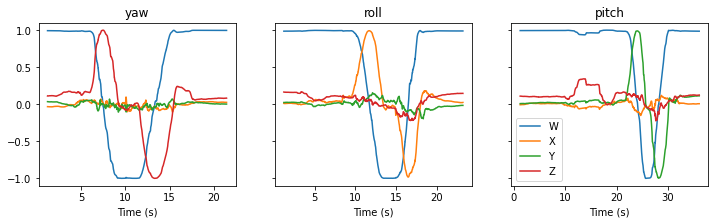

In [14]:
fig, axes = plt.subplots(1,3, sharey=True)
fig.set_facecolor('white')
fig.set_size_inches(12,3)

for iax, w in enumerate(['yaw', 'roll', 'pitch']):
    bno_data = load_bno055(data_root / ('hs_%s_ccw_2turns'%w))
    n_samples = bno_data['quaternion'].shape[0]
    ax = axes[iax]
    ax.set_title(w)
    for i, l in enumerate('WXYZ'):
        ax.plot(bno_data['onix_time'][:n_samples], bno_data['quaternion'][:,i], label=l)
    ax.set_xlabel('Time (s)')
_ = ax.legend(loc=0)


In each cases, I have the W going from 1 to -1 during the first rotation and from -1 to 1 during the second rotation.

In the meantime, Z goes to 1 first and X and Y to -1 first.

That means that we have a ENU frame with a proper right hand rotations. Therefore positive yaw is going to the right, positive roll, lowering the right wing and positive pitch, pointing the nose down.

### Find headstage orientation

Now that I have the quaternion I should be able to get the 3d orientation of the headstage. To show that, compare video with 3d headstage rotating.

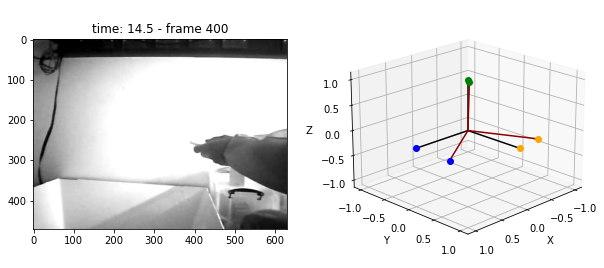

In [15]:
from matplotlib import animation

plot_movie = False

fig = plt.figure(facecolor='white', figsize=[10,5])
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2, projection='3d')


for axis in ['yaw', 'roll', 'pitch']:
    folder = 'hs_%s_ccw_2turns'%axis
    bno_data = load_bno055(data_root / folder)
    n_samples = bno_data['quaternion'].shape[0]
    time = bno_data['onix_time'][:n_samples]

    # find camera frames corresponding to some points
    camera_file = list((data_root / folder).glob('camera_mar*'))
    csv = [f for f in camera_file if f.suffix == '.csv']
    assert len(csv)==1
    cam_ts = pd.read_csv(csv[0], header=None)
    cols = list(cam_ts.columns)
    cols[-1] = 'bonsai'
    cam_ts.columns = cols
    cam_ts['bonsai'] = pd.to_datetime(cam_ts.bonsai)
    cam_ts['bonsai'] = (cam_ts.bonsai - cam_ts.bonsai.min()).dt.total_seconds() + time[0]
    time_cam = cam_ts['bonsai'].values
    mp4 = [f for f in camera_file if f.suffix == '.mp4']
    assert len(mp4)==1
    cam_data = cv2.VideoCapture(str(mp4[0]))
    nframes = int(cam_data.get(cv2.CAP_PROP_FRAME_COUNT))

    # make an axis that we can rotate
    vecs = np.array([[1,0,0],
                     [0,1,0],
                     [0,0,1]], dtype=float)
    def func(frame):
        ax0.clear()
        ax1.clear()
        t0 = time_cam[frame]
        for v, c in zip(vecs, ['blue', 'orange', 'green']):
            ax1.plot([0,v[0]], [0,v[1]], [0,v[2]], color='k')
            ax1.plot(v[0], v[1], v[2], marker='o', color=c)

        cam_data.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
        ret, img = cam_data.read()
        if ret:
            ax0.imshow(img)
        ax0.set_title('time: %.1f - frame %i'%(t0, frame))

        # rotate axis using rotation matrix from quaternion
        i_s = time.searchsorted(t0)
        rot = bno_data['rotation'][i_s]
        rot_v = rot.apply(vecs)

        for v, c in zip(rot_v, ['blue', 'orange', 'green']):
            ax1.plot([0,v[0]], [0,v[1]], [0,v[2]], color='darkred')
            ax1.plot(v[0], v[1], v[2], marker='o', color=c)

        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')
        ax1.set_xlim([-1.1, 1.1])
        ax1.set_ylim([-1.1, 1.1])
        ax1.set_zlim([-1.1, 1.1])
        ax1.view_init(elev=20, azim=45)
    if plot_movie:
        anim = animation.FuncAnimation(fig, func, frames=np.arange(0, nframes-200))
        anim.save(save_root / ('bno_rotation_%s.mp4' % axis), 
                  fps=30, 
                  codec='h264',
                  dpi=75)
    else:
        func(400)

# Reshape acceleration

Now that I know what is the body frame for the quaternion output, let's move the acceleration from body to world frame.


## Put in world coordinates

To do that I will use a dataset where I tilt the body frame to match the 3 world axes and wiggle 5 times along each 

### Find acceleration pulses

(1.2001329285714286, 40.28013421428572)

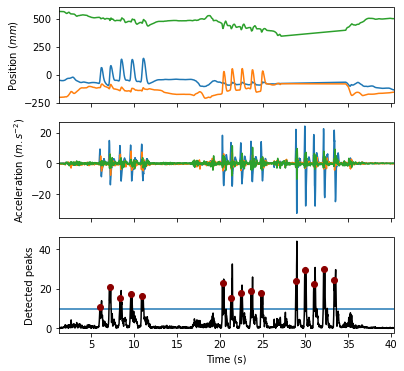

In [16]:
folder = 'hs_accel_along_x_y_z_5each'

bno_data = load_bno055(data_root / folder)
ts4232_data = load_ts4231v1(data_root / folder, 1)
bno_time = bno_data['onix_time'][:len(bno_data['rotation'])]
bno_accel = bno_data['linaccel'][:len(bno_data['rotation']),:]

fig, axes = plt.subplots(3, 1, sharex=True)
fig.set_size_inches(6,6)
axes[0].plot(ts4232_data['onix_time'], ts4232_data['pd_in_arena'])
axes[0].set_ylabel('Position ($mm$)')
axes[1].plot(bno_time, bno_accel)
axes[1].set_ylabel('Acceleration ($m.s^{-2}$)')

# Find a moment where the acceleration is high
pulse = np.abs(bno_accel).sum(axis=1)
local_max = (np.diff(pulse[1:]) < 0) & (np.diff(pulse[:-1]) >= 0)
threshold = 10
high_enough = pulse[1:-1] > threshold
# keep the first in batches of 0.5 seconds
inter = int(0.5/np.diff(time[:2]))
peak_index = np.where(high_enough & local_max)[0] + 1
inter_peak = np.diff(peak_index)
accel_peaks = np.hstack([peak_index[0], peak_index[1:][inter_peak > inter]])

ok = high_enough & local_max
axes[2].axhline(threshold)
axes[2].plot(bno_time, pulse, color='k')
axes[2].plot(bno_time[accel_peaks], pulse[accel_peaks], color='darkred', marker='o', ls='')
axes[2].set_ylabel('Detected peaks')
axes[2].set_xlabel('Time (s)')
axes[1].set_xlim([bno_time[0], bno_time[-1]])

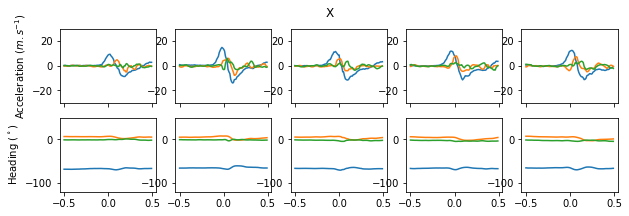

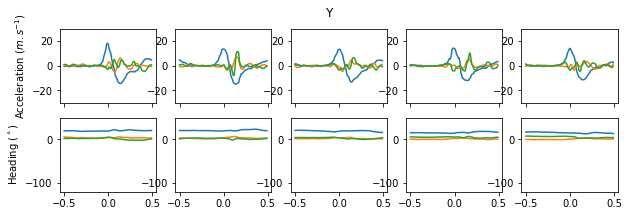

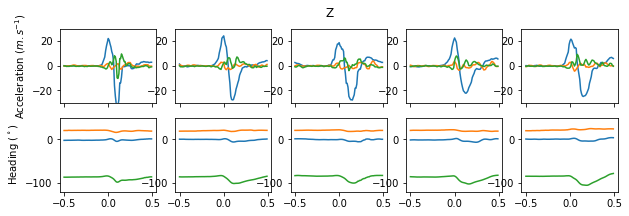

In [17]:
axes_name = ['X', 'Y', 'Z']
for group in range(3):
    peaks = accel_peaks[group * 5: (group + 1) * 5]
    fig, axes = plt.subplots(2,5, sharex=True)
    fig.suptitle(axes_name[group])
    fig.set_size_inches(10,3)
    axes[0,0].set_ylabel('Acceleration ($m.s^{-1}$)')
    axes[1,0].set_ylabel('Heading ($^\circ$)')
    w = np.arange(-50, 50)
    for iax, pk in enumerate(peaks):
        axes[0, iax].plot(bno_time[w + pk] - bno_time[pk], bno_accel[w + pk])
        axes[1, iax].plot(bno_time[w + pk] - bno_time[pk], 
                          bno_data['rotation'].as_euler(seq='zxy', degrees=True)[w + pk])
        axes[0, iax].set_ylim([-30, 30])
        axes[1, iax].set_ylim([-120, 50])

### Rotate frame and acceleration at peak

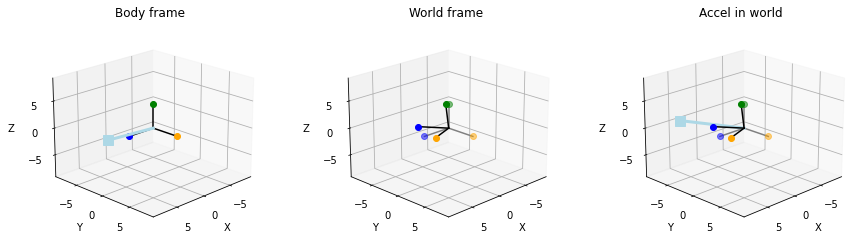

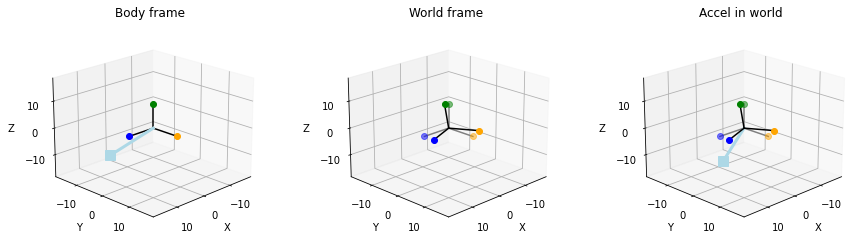

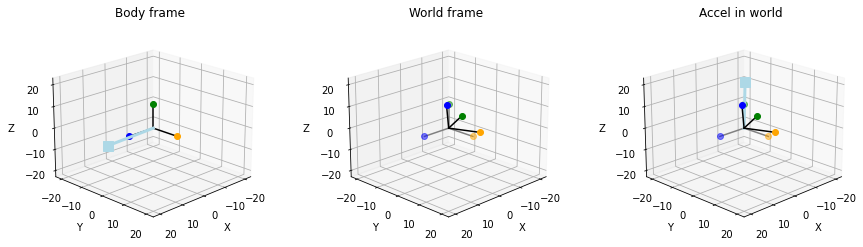

In [18]:
# make an axis that we can rotate
vecs = np.array([[1,0,0],
                 [0,1,0],
                 [0,0,1]], dtype=float)

for ip in [0,5,10]:
    pk = accel_peaks[ip]

    fig = plt.figure(figsize=(15,4))
    ax0 = fig.add_subplot(1,3,1, projection='3d')
    ax0.set_title('Body frame')
    ax1 = fig.add_subplot(1,3,2, projection='3d')
    ax1.set_title('World frame')
    ax2 = fig.add_subplot(1,3,3, projection='3d')
    ax2.set_title('Accel in world')
    
    
    accel = bno_accel[pk]
    m = np.abs(accel).max()

    ax0.plot([0, accel[0]], [0, accel[1]], [0, accel[2]], color='lightblue', lw=3)
    ax0.plot(*accel, color='lightblue', marker='s', ms=10)

    rot = bno_data['rotation'][pk]
    rot_vec = rot.apply(vecs)
    
    rot_accel = rot.apply(accel)
    ax2.plot([0, rot_accel[0]], [0, rot_accel[1]], [0, rot_accel[2]], color='lightblue', lw=3)
    ax2.plot(*rot_accel, color='lightblue', marker='s', ms=10)
    
    
    for x in [ax0, ax1, ax2]:
        for v, c in zip(vecs, ['blue', 'orange', 'green']):
            v = np.array(v) * m*0.5
            x.plot([0,v[0]], [0,v[1]], [0,v[2]], color='k' if x == ax0 else 'grey', zorder=-10)
            x.plot(v[0], v[1], v[2], marker='o', color=c, alpha=1 if x == ax0 else 0.5, zorder=-8)
        if x != ax0:
            for v, c in zip(rot_vec, ['blue', 'orange', 'green']):
                v = np.array(v) * m*0.5
                x.plot([0,v[0]], [0,v[1]], [0,v[2]], color='k')
                x.plot(v[0], v[1], v[2], marker='o', color=c)


        x.set_xlabel('X')
        x.set_ylabel('Y')
        x.set_zlabel('Z')
        x.set_xlim([-m, m])
        x.set_ylim([-m, m])
        x.set_zlim([-m, m])
        x.view_init(elev=20, azim=45)

### Rotate the whole trace

Do the same but for the whole trace. The first two bunch of pulses should be contained in the X/Y plane and be ~90 degrees and the last one should be along the Z axis

(1.2001329285714286, 40.28013421428572)

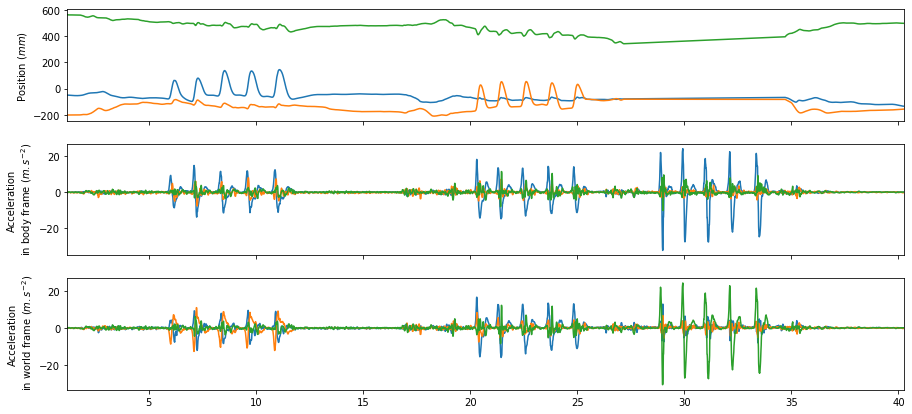

In [19]:
fig, axes = plt.subplots(3, 1, sharex=True)
fig.set_size_inches(15,7)
axes[0].plot(ts4232_data['onix_time'], ts4232_data['pd_in_arena'])
axes[0].set_ylabel('Position ($mm$)')
axes[1].plot(bno_time, bno_accel)
axes[1].set_ylabel('Acceleration\n in body frame ($m.s^{-2}$)')

rot = bno_data['rotation']
rot_accel = rot.apply(bno_accel)
axes[2].plot(bno_time, rot_accel)
axes[2].set_ylabel('Acceleration\n in world frame ($m.s^{-2}$)')
axes[1].set_xlim([bno_time[0], bno_time[-1]])

## Put in arena coordinates

I can assume that the arena is flat and the two Z axes (from the BNO055 and the calibrated ts4232) are the same. However the X and Y are not. The BNO055 is East-North, the arena is closer to South-East, so I need something like 90 degree rotation (+/- 30).

### Use toy data

In [20]:
folder = 'hs_rotation'
ldata = load_ts4231v1(folder=data_root / folder, pd_index=2)
bno = load_bno055(data_root / folder)

heading_quat = bno['rotation'].as_euler(seq='zyx', degrees=True)[bno['onix_time'].searchsorted(ldata['onix_time']), 0]

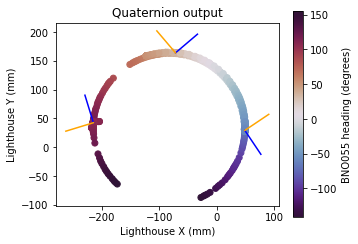

In [21]:
def plot_circl():
    fig = plt.figure(figsize=(5,3.8), facecolor='white')

    ax = fig.add_subplot(1,1,1, aspect='equal')
    sc = ax.scatter(ldata['pd_in_arena'][:,0], ldata['pd_in_arena'][:,1], c=heading_quat, cmap='twilight_shifted')

    # also take 4 points and plot the 2 axes.

    for pt in [200, 400, 600]:
        rot = bno['rotation'][bno['onix_time'].searchsorted(ldata['onix_time'][pt])]
        xy = ldata['pd_in_arena'][pt]
        rot_vec = rot.apply(vecs * 50) 
        for c, v in zip(['blue', 'orange'], rot_vec):
            ax.plot(xy[0] + np.array([0, v[0]]), xy[1] + np.array([0, v[1]]), color=c)


    cb = plt.colorbar(sc)
    ax.set_xlabel('Lighthouse X (mm)')
    ax.set_title('Quaternion output')
    ax.set_ylabel('Lighthouse Y (mm)')
    cb.set_label('BNO055 heading (degrees)')
    fig.subplots_adjust(wspace=0.3)
    return fig

fig = plot_circl()

### Find the angle at which HS faces east

The east is at 55.02 deg in my arena


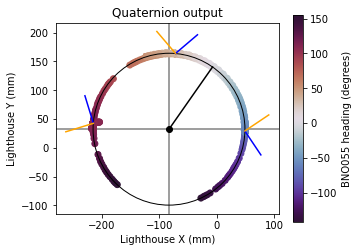

In [22]:
# I want to find the angle to the east (which is heading = 0)

fig = plot_circl()
ax = fig.axes[0]

# find the center of the circle
# (x-xc)^2 +(y-yc)^2 = r^2
# x^2 -2.x.xc + xc^2 + y^2 -2.y.yc + yc^2 = r
# x^2 + y^2 = r + 2.x.xc - xc^2  +2.y.yc - yc^2
# let a = 2.xc, b = 2.yc and c = r -yc^2 - xc^2
# x^2 + y^2 = a.x + b.y + c
# now we have a linear fit of the sum of square

sumofsquare = np.sum(ldata['pd_in_arena'][:,:2]**2, axis=1)

def cost(p):
    # params = xc, yc, r
    x = ldata['pd_in_arena'][:,0]
    y = ldata['pd_in_arena'][:,1]
    pred = p[0]*x + p[1]*y + p[2]
    return np.nansum(np.sqrt((sumofsquare-pred)**2))
    
from scipy.optimize import minimize
p0 = np.array([0,50/2, 200 - 50**2])
fit = minimize(cost, p0)
c = 0.5 * fit.x[:-1]
r = np.sqrt(fit.x[-1] + np.square(c).sum())
from matplotlib.patches import Circle
ellipse = Circle(c, radius=r, facecolor='none', edgecolor='k')
ax.add_patch(ellipse)

ax.axvline(c[0], color='grey', zorder=-1)
ax.axhline(c[1], color='grey', zorder=-1)
ax.plot(*c, 'ko')

# for any point the angle between x axis and the point is
to_center = ldata['pd_in_arena'][:,:2] - c
angl = np.arctan2(*to_center[:,[1,0]].T)
def cost(north):
    return np.sum(np.sqrt((angl+north-(np.deg2rad(heading_quat)))**2))

fitn = minimize(cost, 0)
north = -fitn.x[0]
ax.plot([c[0], c[0] + np.cos(north)*r], [c[1], c[1] + np.sin(north)*r], 'k')

print('The east is at %.2f deg in my arena'%np.rad2deg(north))

### Find the angle of the HS relative to the circle

Angle between X axis and hs: 104.82
Angle between X axis and radius: 175.64
The angle between hs and the radius is: 70.82
The median angle is 62.54


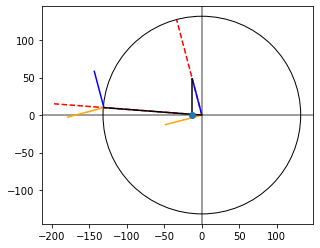

In [23]:
# I also need to know the angle of the headstage relative to the circle
pt = 705

fig = plt.figure()
ax = fig.add_subplot(1,1,1, aspect='equal')
rot = bno['rotation'][bno['onix_time'].searchsorted(ldata['onix_time'][pt])]
xy = ldata['pd_in_arena'][pt]
rot_vec = rot.apply(vecs) * 50
c = 0.5 * fit.x[:-1]
for col, v in zip(['blue', 'orange'], rot_vec):
    ax.plot(xy[0]-c[0] + np.array([0, v[0]]), xy[1]-c[1] + np.array([0, v[1]]), color=col)
    ax.plot(np.array([0, v[0]]), np.array([0, v[1]]), color=col)
ax.plot([0, xy[0]-c[0]], [0, xy[1]-c[1]], color='k')    

ax.axvline(0, color='grey', zorder=-1)
ax.axhline(0, color='grey', zorder=-1)
ellipse = Circle([0,0], radius=r, facecolor='none', edgecolor='k')
ax.add_patch(ellipse)

ax.plot([rot_vec[0,0], rot_vec[0,0]], [0, rot_vec[0,1]], color='k')
ax.plot(rot_vec[0,0], 0, marker='o')

hs_to_x = np.arctan2(rot_vec[0, 1], rot_vec[0, 0])
print('Angle between X axis and hs: %.2f' % np.rad2deg(hs_to_x))
ax.plot([0, np.cos(hs_to_x)*r], [0, np.sin(hs_to_x)*r], 'r--', zorder=-10)

rad_to_x = np.arctan2(xy[1]-c[1], xy[0]-c[0])
print('Angle between X axis and radius: %.2f' % np.rad2deg(rad_to_x))
ax.plot([0, np.cos(rad_to_x)*r*1.5], [0, np.sin(rad_to_x)*r*1.5], 'r--', zorder=-10)

rad_to_hs = rad_to_x-hs_to_x
print('The angle between hs and the radius is: %.2f' % np.rad2deg(rad_to_hs))

# do the same for all the points
rot = bno['rotation'][bno['onix_time'].searchsorted(ldata['onix_time'])]
rot_vecs = [r.apply(vecs) for r in rot]
rad_to_hs = [np.arctan2(xy[1]-c[1], xy[0]-c[0]-np.arctan2(rv[0,1], rv[0,0]))
            for rv, xy in zip(rot_vecs, ldata['pd_in_arena'])]

rad_to_hs = np.nanmedian(rad_to_hs)
print('The median angle is %.2f' % np.rad2deg(rad_to_hs))

### Make transform

The angle I want to rotate by is from east to X axis. That is the sum of the two previous angles

In [24]:
x_to_east = rad_to_hs + north
east_to_x = - x_to_east
print('The world frame needs to be rotated by %.2f degrees to match the arena frame' % np.rad2deg(east_to_x))

world2arena = Rotation.from_euler(seq='z', angles=east_to_x)
arena2world = Rotation.from_euler(seq='z', angles=x_to_east)

The world frame needs to be rotated by -117.57 degrees to match the arena frame


### Test is on acceleration


In [25]:
[f for f in os.listdir(data_root) if f.startswith('hs_acc')]

['hs_accel_along_x_y_z_5each',
 'hs_accel_along_x_multiori',
 'hs_accel_3ori_samehsface',
 'hs_accel_bodyxyz_then_arenaX',
 'hs_accel_along_45deg',
 'hs_accel_along_wall_paralleltoy']

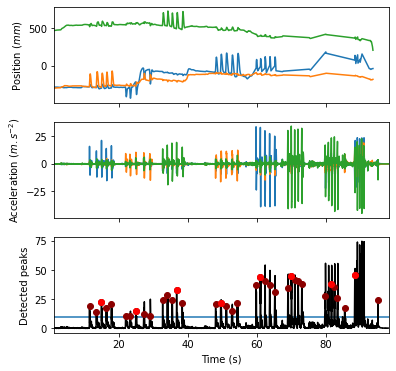

In [26]:
folder = 'hs_accel_bodyxyz_then_arenaX'

bno_data = load_bno055(data_root / folder)
ts4232_data = load_ts4231v1(data_root / folder, 1)
bno_time = bno_data['onix_time'][:len(bno_data['rotation'])]
bno_accel = bno_data['linaccel'][:len(bno_data['rotation']),:]

fig, axes = plt.subplots(3, 1, sharex=True)
fig.set_size_inches(6,6)
axes[0].plot(ts4232_data['onix_time'], ts4232_data['pd_in_arena'])
axes[0].set_ylabel('Position ($mm$)')
axes[1].plot(bno_time, bno_accel)
axes[1].set_ylabel('Acceleration ($m.s^{-2}$)')

# Find a moment where the acceleration is high
pulse = np.abs(bno_accel).sum(axis=1)
local_max = (np.diff(pulse[1:]) < 0) & (np.diff(pulse[:-1]) >= 0)
threshold = 10
high_enough = pulse[1:-1] > threshold
# keep the first in batches of 0.5 seconds
inter = int(0.5/np.diff(time[:2]))
peak_index = np.where(high_enough & local_max)[0] + 1
inter_peak = np.diff(peak_index)
accel_peaks = np.hstack([peak_index[0], peak_index[1:][inter_peak > inter]])

ok = high_enough & local_max
axes[2].axhline(threshold)
axes[2].plot(bno_time, pulse, color='k')
axes[2].plot(bno_time[accel_peaks], pulse[accel_peaks], color='darkred', marker='o', ls='')
axes[2].set_ylabel('Detected peaks')
axes[2].set_xlabel('Time (s)')
axes[1].set_xlim([bno_time[0], bno_time[-1]])

good_peaks = [2, 7, 13, 16, 21, 26, 31, 35]
for pk in good_peaks:
    axes[2].plot(bno_time[accel_peaks[pk]], pulse[accel_peaks[pk]], color='red', marker='o', ls='')

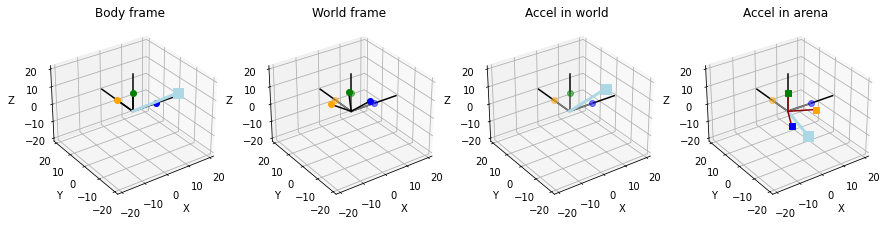

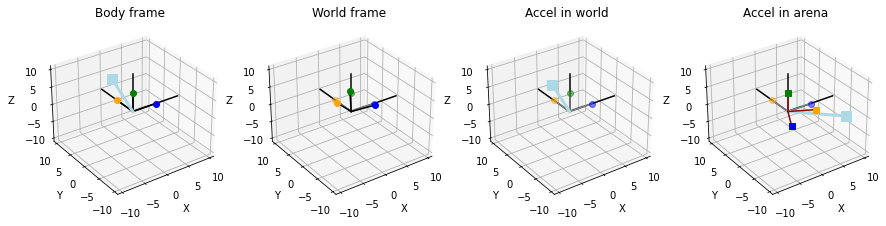

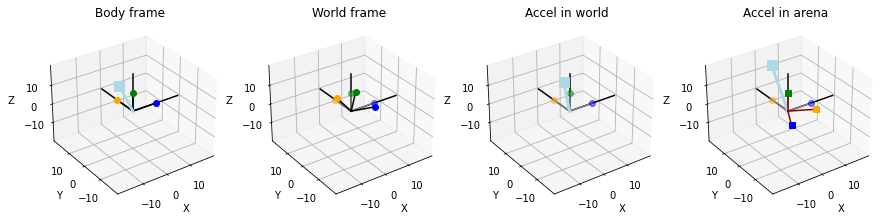

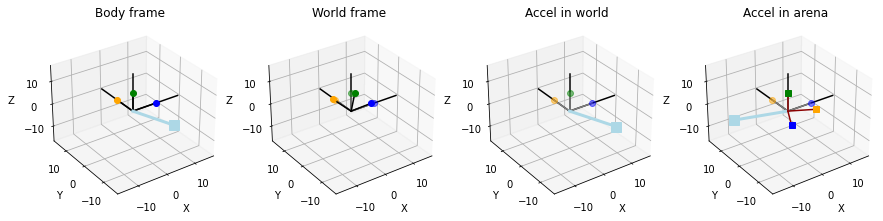

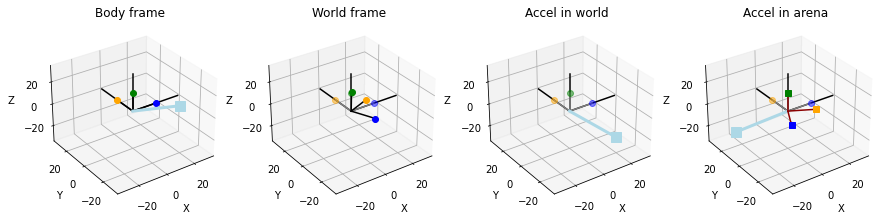

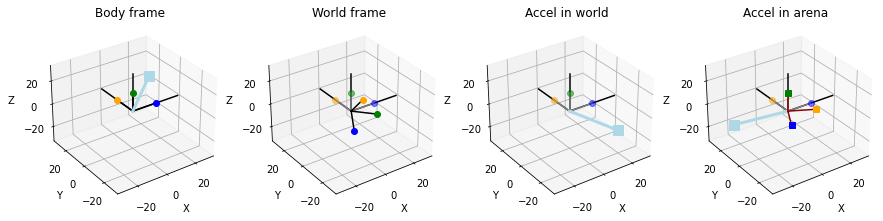

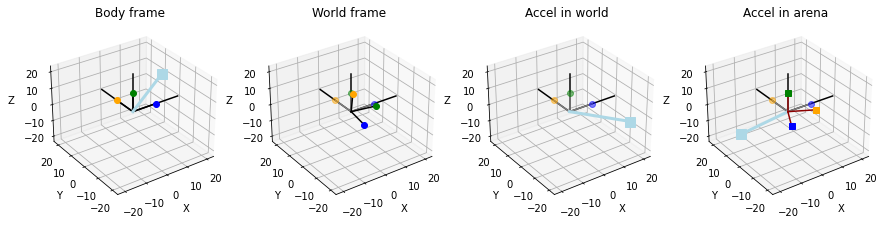

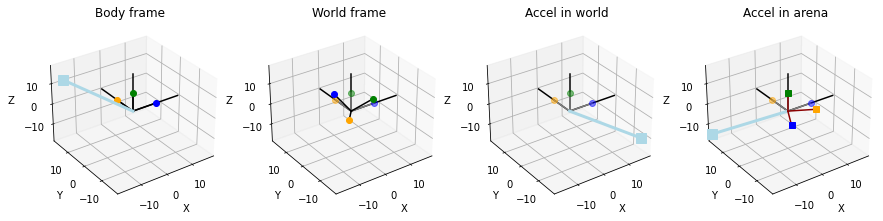

In [27]:
# make an axis that we can rotate

plot_axis_planes = False
vecs = np.array([[1,0,0],
                 [0,1,0],
                 [0,0,1]], dtype=float)

for ip in good_peaks:
    pk = accel_peaks[ip]

    fig = plt.figure(figsize=(15,4))
    ax0 = fig.add_subplot(1,4,1, projection='3d')
    ax0.set_title('Body frame')
    ax1 = fig.add_subplot(1,4,2, projection='3d')
    ax1.set_title('World frame')
    ax2 = fig.add_subplot(1,4,3, projection='3d')
    ax2.set_title('Accel in world')
    ax3 = fig.add_subplot(1,4,4, projection='3d')
    ax3.set_title('Accel in arena')
    
    
    accel = bno_accel[pk]
    m = np.abs(accel).max()

    ax0.plot([0, accel[0]], [0, accel[1]], [0, accel[2]], color='lightblue', lw=3)
    ax0.plot(*accel, color='lightblue', marker='s', ms=10)

    rot = bno_data['rotation'][pk]
    rot_vec = rot.apply(vecs)
    
    rot_accel = rot.apply(accel)
    ax2.plot([0, rot_accel[0]], [0, rot_accel[1]], [0, rot_accel[2]], color='lightblue', lw=3)
    ax2.plot(*rot_accel, color='lightblue', marker='s', ms=10)
    
    arena_accel = world2arena.apply(rot_accel)
    ax3.plot([0, arena_accel[0]], [0, arena_accel[1]], [0, arena_accel[2]], color='lightblue', lw=3)
    ax3.plot(*arena_accel, color='lightblue', marker='s', ms=10)
    arena_vec = world2arena.apply(vecs)

    
    for x in [ax0, ax1, ax2, ax3]:
        for v, c in zip(vecs, ['blue', 'orange', 'green']):
            v = np.array(v) * m*0.5
            x.plot([0,v[0]], [0,v[1]], [0,v[2]], color='k' if x == ax0 else 'grey', zorder=-10)
            x.plot(v[0], v[1], v[2], marker='o', color=c, alpha=1 if x == ax0 else 0.5, zorder=-8)
        if x in [ax1]:
            for v, c in zip(rot_vec, ['blue', 'orange', 'green']):
                v = np.array(v) * m*0.5
                x.plot([0,v[0]], [0,v[1]], [0,v[2]], color='k')
                x.plot(v[0], v[1], v[2], marker='o', color=c)
        if x == ax3:
            for v, c in zip(arena_vec, ['blue', 'orange', 'green']):
                v = np.array(v) * m*0.5
                x.plot([0,v[0]], [0,v[1]], [0,v[2]], color='darkred')
                x.plot(v[0], v[1], v[2], marker='s', color=c)
        if plot_axis_planes:
            X = np.arange(-m, m)
            Y = np.arange(-m, m)
            X, Y = np.meshgrid(X, Y)
            x.plot_surface(X,Y, np.zeros_like(X), color='grey', zorder=-100, alpha=0.1)
            x.plot_surface(X,np.zeros_like(X), Y, color='grey', zorder=-100, alpha=0.1)
            x.plot_surface(np.zeros_like(X),X, Y, color='grey', zorder=-100, alpha=0.1)
        x.plot([0, m], [0,0], [0,0], color='k', zorder=-100)
        x.plot([0, 0], [0,m], [0,0], color='k', zorder=-100)
        x.plot([0, 0], [0,0], [0,m], color='k', zorder=-100)
        x.grid('off')
        x.set_xlabel('X')
        x.set_ylabel('Y')
        x.set_zlabel('Z')
        x.set_xlim([-m, m])
        x.set_ylim([-m, m])
        x.set_zlim([-m, m])
        x.view_init(elev=30, azim=-125)


In [28]:
ax = fig.add_subplot(2,2,3, aspect='equal')
sc = ax.scatter(ldata['pd_in_arena'][b:e,0], ldata['pd_in_arena'][b:e,1], c=angl, cmap='twilight_shifted')
cb = plt.colorbar(sc)
ax.set_xlabel('Lighthouse X (mm)')
ax.set_title('Trigo heading')
ax.set_ylabel('Lighthouse Y (mm)')


# make a transform that moves the north along the x axis
north2arena = Rotation.from_euler(angles=-north, seq='z')

renorthed = north2arena * bno['rotation']
corrected_heading = renorthed.as_euler(seq='zyx', degrees=True)[bno['onix_time'].searchsorted(ldata['onix_time']), 0]

ax = fig.add_subplot(2,2,4, aspect='equal')
sc = ax.scatter(ldata['pd_in_arena'][b:e,0], ldata['pd_in_arena'][b:e,1], c=corrected_heading[b:e], cmap='twilight_shifted')
cb = plt.colorbar(sc)
ax.set_xlabel('Lighthouse X (mm)')
ax.set_title('Corrected heading')
ax.set_ylabel('Lighthouse Y (mm)')
cb.set_label('BNO055 heading (degrees)')
print('The north is at %.2f deg in my arena'%np.rad2deg(-north))

NameError: name 'b' is not defined

## Look a the mouse dataset

In [ ]:
fnames = os.listdir(data_root / 'mouse_with_roomlight')
ln_light_data = dict()
for lindex in (1, 2):
    dat = [n for n in fnames if n.startswith('lighthouse_matrix%d'%lindex)]
    assert len(dat) == 1
    dat = dat[0]
    data = np.fromfile(data_root / 'mouse_with_roomlight' / dat, dtype='double')
    data = data.reshape([-1, 3])
    ln_light_data['pd%d'%lindex] = data
ln_centered = {k: v-origin for k,v in ln_light_data.items()}
ln_rotated = {k: np.array(np.matmul(A_old2new, v.T)).T for k,v in ln_centered.items()}
fn = [f for f in fnames if f.startswith('lighthouse2_time')]
assert len(fn) == 1
light_df = pd.read_csv(data_root / 'mouse_with_roomlight' / fn[0])
light_df.head()

In [ ]:
fig = plt.figure(figsize=(10,10))
axes = [fig.add_subplot(2,2, i+1, projection='3d') for i in range(2)]
for k, v in ln_light_data.items():
    iax = int(k[-1]) - 1
    #axes[iax].plot([-350, -350, 350, 350, -350], [-350, 350, 350, -350, -350], [0, 0, 0, 0, 0], color='k', zorder=-100)
    #axes[iax].plot([-500, -500, 500, 500, -500], [-500, 500, 500, -500, -500], [400, 400, 400, 400, 400], color='k', zorder=-100)
    axes[iax].scatter(v[:,0],v[:,1],v[:,2], s=5, alpha=0.1)
axes = [fig.add_subplot(2,2, i+3) for i in range(2)]
for k, v in ln_light_data.items():
    iax = int(k[-1]) - 1
    axes[iax].scatter(v[:,0], v[:,1], c=v[:,2])
    #axes[iax].plot([-350, -350, 350, 350, -350], [-350, 350, 350, -350, -350], color='k', zorder=-100)



In [ ]:
fig = plt.figure(figsize=(10,10))
axes = [fig.add_subplot(2,2, i+1, projection='3d') for i in range(2)]
for k, v in ln_rotated.items():
    iax = int(k[-1]) - 1
    axes[iax].plot([-350, -350, 350, 350, -350], [-350, 350, 350, -350, -350], [0, 0, 0, 0, 0], color='k', zorder=-100)
    axes[iax].plot([-500, -500, 500, 500, -500], [-500, 500, 500, -500, -500], [400, 400, 400, 400, 400], color='k', zorder=-100)
    axes[iax].scatter(v[:,0],v[:,1],v[:,2], s=5, alpha=0.1)
axes = [fig.add_subplot(2,2, i+3) for i in range(2)]
for k, v in ln_rotated.items():
    iax = int(k[-1]) - 1
    axes[iax].scatter(v[:,0], v[:,1], c=v[:,2])
    axes[iax].plot([-350, -350, 350, 350, -350], [-350, 350, 350, -350, -350], color='k', zorder=-100)




# Look at accelerometer data

First look at non calibrated file

# Find rotation direction

For that use a dataset where there is mvt

In [ ]:
# use dataset with rotation to find if it's clockwise or anti
folder = 'hs_rotation'
bno = load_bno055(data_root / folder)
rot = Rotation.from_quat(bno['quaternion'][:,[1,2,3,0]])
extrinsic_eul = rot.as_euler(seq='zxy', degrees=True)
time = bno['csv']['data_clk'] / 42e6


# find camera frames corresponding to some points
camera_file = list((data_root / folder).glob('camera_mar*'))
csv = [f for f in camera_file if f.suffix == '.csv']
assert len(csv)==1
cam_ts = pd.read_csv(csv[0], header=None)
cols = list(cam_ts.columns)
cols[-1] = 'bonsai'
cam_ts.columns = cols
cam_ts['bonsai'] = pd.to_datetime(cam_ts.bonsai)
cam_ts['bonsai'] = (cam_ts.bonsai - cam_ts.bonsai.min()).dt.total_seconds() + time[0]
mp4 = [f for f in camera_file if f.suffix == '.mp4']
assert len(mp4)==1

cam_data = cv2.VideoCapture(str(mp4[0]))
nframes = int(cam_data.get(cv2.CAP_PROP_FRAME_COUNT))

fig, ax = plt.subplots(1,1)
fig.set_size_inches(14,2)
ax.plot(time, extrinsic_eul[:,0])

fig, axes = plt.subplots(2,4)
fig.set_size_inches(15,5)
for ipts, t in enumerate([3,27, 32.5, 34, 36, 37, 39, 41]):
    angl = extrinsic_eul[time.searchsorted(t),0]
    ax.plot(t, angl, 'o')
    i_frame = cam_ts['bonsai'].searchsorted(t)
    cam_data.set(cv2.CAP_PROP_POS_FRAMES, i_frame-1)
    ret, img = cam_data.read()
    if ret:
        axes.flatten()[ipts].imshow(img)
    axes.flatten()[ipts].set_title('time: %s, angle = %d'%(t, angl))
ax.set_ylabel('Heading (degrees)')
ax.set_xlabel('Time (s)')
    
cam_data.release()
#gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

So the mvt is clockwise, with x ~ -125 degrees ... IF we consider the euler output. Counterclockwise with the quaternion

In [ ]:
folder = 'hs_rotation'
ldata = load_ts4231v1(folder=data_root / folder, pd_index=2)
bno = load_bno055(data_root / folder)

heading = bno['euler'][bno['onix_time'].searchsorted(ldata['onix_time']), 0]
#heading[heading>180] = heading[heading>180]-360
heading_quat = bno['rotation'].as_euler(seq='zyx', degrees=True)[bno['onix_time'].searchsorted(ldata['onix_time']), 0]
t = [0,300]
b,e = ldata['onix_time'].searchsorted(t)


fig = plt.figure(figsize=(10,10), facecolor='white')
ax = fig.add_subplot(2,2,1, aspect='equal')
sc = ax.scatter(ldata['pd_in_arena'][b:e,0], ldata['pd_in_arena'][b:e,1], c=heading[b:e], cmap='twilight_shifted')
cb = plt.colorbar(sc)
ax.set_xlabel('Lighthouse X (mm)')
ax.set_title('Euler output')
ax.set_ylabel('Lighthouse Y (mm)')
cb.set_label('BNO055 heading (degrees)')

ax = fig.add_subplot(2,2,2, aspect='equal')
sc = ax.scatter(ldata['pd_in_arena'][b:e,0], ldata['pd_in_arena'][b:e,1], c=heading_quat[b:e], cmap='twilight_shifted')
cb = plt.colorbar(sc)
ax.set_xlabel('Lighthouse X (mm)')
ax.set_title('Quaternion output')
ax.set_ylabel('Lighthouse Y (mm)')
cb.set_label('BNO055 heading (degrees)')
fig.subplots_adjust(wspace=0.3)

# find the center of the circle
# (x-xc)^2 +(y-yc)^2 = r^2
# x^2 -2.x.xc + xc^2 + y^2 -2.y.yc + yc^2 = r
# x^2 + y^2 = r + 2.x.xc - xc^2  +2.y.yc - yc^2
# let a = 2.xc, b = 2.yc and c = r -yc^2 - xc^2
# x^2 + y^2 = a.x + b.y + c
# now we have a linear fit of the sum of square

sumofsquare = np.sum(ldata['pd_in_arena'][:,:2]**2, axis=1)

def cost(p):
    # params = xc, yc, r
    x = ldata['pd_in_arena'][:,0]
    y = ldata['pd_in_arena'][:,1]
    pred = p[0]*x + p[1]*y + p[2]
    return np.nansum(np.sqrt((sumofsquare-pred)**2))
    
from scipy.optimize import minimize
p0 = np.array([0,50/2, 200 - 50**2])
fit = minimize(cost, p0)
c = 0.5 * fit.x[:-1]
r = np.sqrt(fit.x[-1] + np.square(c).sum())
from matplotlib.patches import Circle
ellipse = Circle(c, radius=r, facecolor='none', edgecolor='k')
ax.add_patch(ellipse)

ax.axvline(c[0], color='grey', zorder=-1)
ax.axhline(c[1], color='grey', zorder=-1)
ax.plot(*c, 'ko')

# for any point the angle between x axis and the point is
to_center = ldata['pd_in_arena'][:,:2] - c
angl = np.arctan2(*to_center[:,[1,0]].T)
cb.set_label('BNO055 heading (degrees)')
def cost(north):
    return np.sum(np.sqrt((angl+north-(np.deg2rad(heading_quat)))**2))

fitn = minimize(cost, 0)
north = fitn.x[0]
ax.plot([c[0], c[0] + np.cos(-north)*r], [c[1], c[1] + np.sin(-north)*r], 'k')

ax = fig.add_subplot(2,2,3, aspect='equal')
sc = ax.scatter(ldata['pd_in_arena'][b:e,0], ldata['pd_in_arena'][b:e,1], c=angl, cmap='twilight_shifted')
cb = plt.colorbar(sc)
ax.set_xlabel('Lighthouse X (mm)')
ax.set_title('Trigo heading')
ax.set_ylabel('Lighthouse Y (mm)')


# make a transform that moves the north along the x axis
north2arena = Rotation.from_euler(angles=-north, seq='z')

renorthed = north2arena * bno['rotation']
corrected_heading = renorthed.as_euler(seq='zyx', degrees=True)[bno['onix_time'].searchsorted(ldata['onix_time']), 0]

ax = fig.add_subplot(2,2,4, aspect='equal')
sc = ax.scatter(ldata['pd_in_arena'][b:e,0], ldata['pd_in_arena'][b:e,1], c=corrected_heading[b:e], cmap='twilight_shifted')
cb = plt.colorbar(sc)
ax.set_xlabel('Lighthouse X (mm)')
ax.set_title('Corrected heading')
ax.set_ylabel('Lighthouse Y (mm)')
cb.set_label('BNO055 heading (degrees)')
print('The north is at %.2f deg in my arena'%np.rad2deg(-north))

## Turn heading from north to arena

Example with some fixed position

In [ ]:
# use dataset with know position
folders = data_root.glob('hs_facing*')

fix_orientation = dict()
for f in folders:
    fix_orientation[f] = load_bno055(f)

In [ ]:
fig = plt.figure(figsize=(10,5))
ax0 = plt.subplot(1,2,1, projection='3d')
ax1 = plt.subplot(1,2,2, projection='3d')
for f, d in fix_orientation.items():
    name = f.stem[10:]
    m = np.median(d['rotation'].as_matrix(), axis=0)
    v = m.dot(np.array([1,0,0]))
    ax0.plot([0, v[0]], [0, v[1]], [0, v[2]], '-o', label=name)
    v = north2arena.apply(v)
    ax1.plot([0, v[0]], [0, v[1]], [0, v[2]], '-o', label=name)

ax0.legend(loc=0)
fig.suptitle('HS heading ...')
ax0.set_title('... in world frame')
ax1.set_title('... in arena frame')

for x in ax0, ax1:
    x.plot([0,1], [0,0], [0,0], color='k')
    x.plot([0,0], [0,1], [0,0], color='k')
    x.view_init(azim=-45, elev=40)
    x.set_xlabel('x')
    x.set_ylabel('y')
    x.set_zlabel('z')

# Change acceleration frame

## Move from body to world frame

Step 1 is to go from the body frame of the headstage to the world frame. This should be simply applying the inverse of rotation given by the orientation quaternion to the accelerometer data.

To check data, use a dataset with acceleration along the south-north axis but with 4 headstage orientations (X facing north, Y facing north, -X facing north and Z facing north)

In [ ]:
[f.stem for f in list(data_root.glob('*accel*'))]

In [ ]:
def hamiltion(p, q):
    """Hamilton product of two X,Y,Z,W quaternions"""
    b1,c1,d1,a1 = p
    b2,c2,d2,a2 = q
    out = [a1*b2 + b1*a2 + c1*d2 - d1*c2,
           a1*c2 - b1*b2 + c1*a2 + d1*b2,
           a1*d2 + b1*c2 - c1*b2 + d1*a2,
           a1*a2 - b1*b2 - c1*c2 - d1*d2 
          ]
    return np.array(out)
    
def conjugate(q):
    """Conjugate of a X,Y,Z,W quaternion"""
    q_star = np.array(q)
    q_star[:-1] *= -1
    return q_star

In [ ]:
for folder in data_root.glob('*accel*'):

    bno_data = load_bno055(data_root / folder)
    ts4232_data = load_ts4231v1(data_root / folder, 2)

    fig, axes = plt.subplots(2,1, sharex=True)
    fig.set_size_inches(7,5)
    filt = bno_data['linaccel'].cumsum(axis=0)
    w = 10
    filt = (filt[w:,:]-filt[:-w,:])/w
    for i in range(3):
        # axes[1].plot(bno_data['onix_time'], bno_data['linaccel'][:,i])
        axes[1].plot(bno_data['onix_time'][int(w/2):-int(w/2)], filt[:,i])
        axes[0].plot(ts4232_data['onix_time'], ts4232_data['pd_in_arena'][:,i])
        #axes[2].plot(bno_data['onix_time'][int(w/2):-int(w/2)], filt[:,i].cumsum())
    axes[0].set_ylabel('Pos from TS4232')
    axes[1].set_ylabel('Accel from BNO055')
    #axes[2].set_ylabel('Speed from accel')
    axes[1].set_xlim([bno_data['onix_time'][0], bno_data['onix_time'][-1]])
    axes[0].set_title(folder.stem)
    """    zm = [14.9, 18.5]
    for x in axes.flatten():
        for l in zm:
            x.axvline(l, color='k', zorder=-10)
    axes[0,0].set_xlim([zm[0]-1,zm[1]+1])"""

In [ ]:
r = heading[0]
print(np.rad2deg(r.magnitude()))
print(heading[0].as_euler('xyz', degrees=True))


In [ ]:
for folder in ['hs_accel_along_%s'%w for w in 'xy']:#data_root.glob('hs_accel_along_*'):
    folder = data_root / folder
    bno_data = load_bno055(data_root / folder)
    ts4232_data = load_ts4231v1(data_root / folder, 2)
    
    fig1, ax = plt.subplots(1,1)
    fig1.set_size_inches(7,2)
    ax.set_title(folder.stem)
    fig, axes = plt.subplots(2,2, sharex=True)
    fig.set_size_inches(15,5)
    heading = Rotation.from_quat(bno_data['quaternion'][:,[1,2,3,0]])
    accel = bno_data['linaccel'][:len(heading)]
    time = bno_data['onix_time'][:len(heading)]
    ax.plot(time, heading.as_euler(seq='zxy', degrees=True))
    #accel_in_world = np.einsum('...i,...ij->...j' ,  accel, heading.inv().as_matrix())
    #accel_in_world = np.einsum('...ij,...j->...i', heading.as_matrix(),  accel)

    accel_in_world = np.zeros_like(accel)
    quat = np.array(bno_data['quaternion'][:,[1,2,3,0]]).copy()
    quat[:,:3] = -quat[:,:3]
    accel_in_world[:, 0] = (1-2*(quat[:, 1]*quat[:, 1] + quat[:, 2]*quat[:, 2]))*accel[:, 0] +   (2*(quat[:, 0]*quat[:, 1] + quat[:, 3]*quat[:, 2]))*accel[:, 1] +   (2*(quat[:, 0]*quat[:, 2] - quat[:, 3]*quat[:, 1]))*accel[:, 2];  
    accel_in_world[:, 1] =   (2*(quat[:, 0]*quat[:, 1] - quat[:, 3]*quat[:, 2]))*accel[:, 0] + (1-2*(quat[:, 0]*quat[:, 0] + quat[:, 2]*quat[:, 2]))*accel[:, 1] +   (2*(quat[:, 1]*quat[:, 2] + quat[:, 3]*quat[:, 0]))*accel[:, 2];
    accel_in_world[:, 2] =   (2*(quat[:, 0]*quat[:, 2] + quat[:, 3]*quat[:, 1]))*accel[:, 0] +   (2*(quat[:, 1]*quat[:, 2] - quat[:, 3]*quat[:, 0]))*accel[:, 1] + (1-2*(quat[:, 0]*quat[:, 0] + quat[:, 1]*quat[:, 1]))*accel[:, 2];

    accel_in_world = heading.apply(accel, inverse=False)
    accel_in_arena = recenter_azimuth.apply(inverse_rotation.apply(accel_in_world))
    w = 10
    
    #for i in range(3):
        # axes[1].plot(time, bno_data['linaccel'][:,i])
    axes[0,0].plot(ts4232_data['onix_time'], ts4232_data['pd_in_arena'])#[:,i])
    axes[1,0].plot(time, accel)
    axes[1,0].set_title('Headstage frame')

    axes[0,1].plot(time, accel_in_world)
    axes[0,1].set_title('World frame')
    
    axes[1,1].plot(time, accel_in_arena)
    axes[1,1].set_title('Arena frame')

    
    #axes[2,1].plot(time, accel_in_world.cumsum(axis=0))

    axes[0,0].set_ylabel('Pos from TS4232')
    axes[1,0].set_ylabel('Accel from BNO055')
    #axes[2,0].set_ylabel('Speed from accel')
    axes[1,0].set_xlim([time[0], time[-1]])
    #axes[2,0].set_xlim([10,25])
    axes[1,0].set_xlabel('Time (s)')
    axes[0,0].set_title(folder.stem)
    """    zm = [14.9, 18.5]
    for x in axes.flatten():
        for l in zm:
            x.axvline(l, color='k', zorder=-10)
    axes[0,0].set_xlim([zm[0]-1,zm[1]+1])"""

In [ ]:
for folder in data_root.glob('*neuman*'):

    bno_data = load_bno055(data_root / folder)
    ts4232_data = load_ts4231v1(data_root / folder, 1)
    
    fig1, ax = plt.subplots(1,1)
    fig1.set_size_inches(7,2)
    ax.set_title(folder.stem)
    fig, axes = plt.subplots(2,2, sharex=True)
    fig.set_size_inches(15,5)
    heading = Rotation.from_quat(bno_data['quaternion'][:,[1,2,3,0]])
    accel = bno_data['linaccel'][:len(heading)]
    time = bno_data['onix_time'][:len(heading)]
    ax.plot(time, heading.as_euler(seq='xyz', degrees=True))
    #accel_in_world = np.einsum('...i,...ij->...j' ,  accel, heading.inv().as_matrix())
    #accel_in_world = np.einsum('...ij,...j->...i', heading.as_matrix(),  accel)
    """
    accel_in_world = np.zeros_like(accel)
    quat = np.array(bno_data['quaternion'][:,[1,2,3,0]])
    quat[:,:3] = -quat[:,:3]
    accel_in_world[:, 0] = (1-2*(quat[:, 1]*quat[:, 1] + quat[:, 2]*quat[:, 2]))*accel[:, 0] +   (2*(quat[:, 0]*quat[:, 1] + quat[:, 3]*quat[:, 2]))*accel[:, 1] +   (2*(quat[:, 0]*quat[:, 2] - quat[:, 3]*quat[:, 1]))*accel[:, 2];  
    accel_in_world[:, 1] =   (2*(quat[:, 0]*quat[:, 1] - quat[:, 3]*quat[:, 2]))*accel[:, 0] + (1-2*(quat[:, 0]*quat[:, 0] + quat[:, 2]*quat[:, 2]))*accel[:, 1] +   (2*(quat[:, 1]*quat[:, 2] + quat[:, 3]*quat[:, 0]))*accel[:, 2];
    accel_in_world[:, 2] =   (2*(quat[:, 0]*quat[:, 2] + quat[:, 3]*quat[:, 1]))*accel[:, 0] +   (2*(quat[:, 1]*quat[:, 2] - quat[:, 3]*quat[:, 0]))*accel[:, 1] + (1-2*(quat[:, 0]*quat[:, 0] + quat[:, 1]*quat[:, 1]))*accel[:, 2];
    """
    accel_in_world = heading.apply(accel, inverse=True)
    accel_in_arena = recenter_azimuth.apply(inverse_rotation.apply(accel_in_world))
    w = 10
    
    #for i in range(3):
        # axes[1].plot(time, bno_data['linaccel'][:,i])
    axes[0,0].plot(ts4232_data['onix_time'], ts4232_data['pd_in_arena'])#[:,i])
    axes[1,0].plot(time, accel)
    axes[1,0].set_title('Headstage frame')

    axes[0,1].plot(time, accel_in_world)
    axes[0,1].set_title('World frame')
    
    axes[1,1].plot(time, accel_in_arena)
    axes[1,1].set_title('Arena frame')

    
    #axes[2,1].plot(time, accel_in_world.cumsum(axis=0))

    axes[0,0].set_ylabel('Pos from TS4232')
    axes[1,0].set_ylabel('Accel from BNO055')
    #axes[2,0].set_ylabel('Speed from accel')
    axes[1,0].set_xlim([time[0], time[-1]])
    #axes[2,0].set_xlim([10,25])
    axes[1,0].set_xlabel('Time (s)')
    axes[0,0].set_title(folder.stem)
    """    zm = [14.9, 18.5]
    for x in axes.flatten():
        for l in zm:
            x.axvline(l, color='k', zorder=-10)
    axes[0,0].set_xlim([zm[0]-1,zm[1]+1])"""

In [ ]:
Rotation.from_quat? x,y,z,w

In [ ]:
heading.apply(accel, inverse=True)[10]

In [ ]:
accel_in_world[10]

# Now look at actual dataset with a mouse

In [ ]:
# Do it for on example time
folder = 'mouse_with_roomlight'

# load IMU data (light house was already laoded above)
bno_mouse = load_bno055(data_root / folder)
ts_data = load_ts4231v1(data_root / folder, 2)

imu_time = bno_mouse['csv']['frame_clk'] / 42e6
pd_data = ts_data['pd_in_arena']/1e3
pd_time = ts_data['onix_time']
# add a calib flag
bno_mouse['is_calib'] = np.sum(np.array(bno_mouse['csv'][['accel_calib', 'gyr_calib', 'magn_calib']], 
                                        dtype=int),
                               axis=1) == 3

heading = Rotation.from_quat(bno_mouse['quaternion'][:,[1,2,3,0]])
# move the acceleration in the world frame
accel_in_world = heading.apply(bno_mouse['linaccel'], inverse=False)
# reorient
accel_in_world = recenter_azimuth.apply(inverse_rotation.apply(accel_in_world))

In [ ]:
# do it point by point an plot result
from matplotlib import animation


fig = plt.figure(figsize=(5,5), facecolor='white')
ax = fig.add_subplot(1,1,1, projection='3d')

extrapol = np.zeros([len(pd_time)-2, 3]) + np.nan

def func(frames):
    ax.clear()
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')

    i0_pd = frames + 1
    t0_pd = pd_time[i0_pd]
    t1_pd = pd_time[i0_pd + 1]
    p0 = pd_data[i0_pd]
    p1 = pd_data[i0_pd + 1]
    s0 = (pd_data[i0_pd] - pd_data[i0_pd-1]) / (t0_pd - pd_time[i0_pd-1])

    i0_imu = imu_time.searchsorted(t0_pd, side='left')
    i1_imu = imu_time.searchsorted(t1_pd, side='left')
    if i1_imu <= i0_imu:
        ax.plot(0,0,0, marker='o', ms=50, color='r')
        return
    accel_0 = accel_in_world[i0_imu:i1_imu]

    speed_imu = (np.cumsum(accel_0, axis=0).T * np.diff(imu_time[i0_imu:i1_imu+1])).T + s0
    pos_imu = (np.cumsum(speed_imu, axis=0).T * np.diff(imu_time[i0_imu:i1_imu+1])).T + p0
    ax.plot(*[pd_data[np.max([0, i0_pd-500]):i0_pd+1,i] for i in range(3)], color='k')
    ax.plot(*p0, color='purple', marker='o')
    ax.plot(*p1, color='green', marker='o')

    ax.plot(*[(p0[i], p0[i]+s0[i]) for i in range(3)], color='purple')
    p = np.vstack([p0[np.newaxis,:], pos_imu])
    for ip in range(len(pos_imu)):
        ax.plot(*[(p[ip][i], p[ip+1][i]) for i in range(3)], color='orange')
    color = 'green' if np.all(bno_mouse['is_calib'][i0_imu:i1_imu]) else 'red'
    ax.plot(*pos_imu[-1], color=color, marker='s')
    extrapol[frames,:] = pos_imu[-1]
    
    ax.set_xlim(np.array([-0.2,0.2]))
    ax.set_ylim(np.array([-0.2,0.2]))
    ax.set_zlim(np.array([0,0.1]))

    
#func(2000)
anim = animation.FuncAnimation(fig, func, frames=np.arange(5000, 6000))#len(pd_time)-2)#
anim.save(save_root / 'tracking_extrapolation.mp4', fps=len(pd_time)/(pd_time[-1]-pd_time[0]), codec='jpeg2000',
         dpi=150)

In [ ]:
d = extrapol[:-1] - pd_data[1:]
speed = pd_data[1:]-pd_data[:-1]
d_speed = pd_data[1:] + speed
d2 = pd_data[:-1] - pd_data[1:]
a = np.linalg.norm(d, axis=1)*1000
a2 = np.linalg.norm(d2, axis=1)*1000
plt.hist(a, bins=np.arange(0,20, 0.1), histtype='step', density=True)
plt.hist(a2, bins=np.arange(0,20, 0.1), histtype='step', density=True)
print(np.nanmedian(a))
print(np.nanmedian(a2))

In [ ]:
len(pd_time)

In [ ]:
frames=0
i0_pd = frames + 1
t0_pd = pd_time[i0_pd]
t1_pd = pd_time[i0_pd + 1]
p0 = pd_data[i0_pd]
p1 = pd_data[i0_pd + 1]
s0 = (pd_data[i0_pd] - pd_data[i0_pd-1]) / (t0_pd - pd_time[i0_pd-1])

i0_imu = imu_time.searchsorted(t0_pd, side='left')
i1_imu = imu_time.searchsorted(t1_pd, side='left')
accel_0 = accel_in_world[i0_imu:i1_imu]

speed_imu = (np.cumsum(accel_0, axis=0).T * np.diff(imu_time[i0_imu:i1_imu+1])).T + s0
pos_imu = (np.cumsum(speed_imu, axis=0).T * np.diff(imu_time[i0_imu:i1_imu+1])).T + p0
ax.plot(*[pd_data[:i0_pd+1,i] for i in range(3)], color='k')
ax.plot(*p0, color='purple', marker='o')
ax.plot(*p1, color='green', marker='o')

ax.plot(*[(p0[i], p0[i]+s0[i]) for i in range(3)], color='purple')
p = np.vstack([p0[np.newaxis,:], pos_imu])
for ip in range(len(pos_imu)):
    ax.plot(*[(p[ip][i], p[ip+1][i]) for i in range(3)], color='orange')
ax.plot(*pos_imu[-1], color='green', marker='s')
extrapol[frames,:] = pos_imu[-1]

In [ ]:
out = load_bno055(data_root / 'mouse_with_roomlight')
dt =  np.median(np.diff(out['csv']['frame_clk'])/42e6)
time = out['csv']['frame_clk'] / 42e6

fig, axes = plt.subplots(1,3)
fig.set_size_inches([10,2])
for i in range(3):
    axes[i].scatter(time, out['euler'][:,i])
axes[i]

In [ ]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches([10,2])
for i in range(3):
    axes[i].plot(time, out['gravity'][:,i], 'o-')


In [ ]:
fig, axes = plt.subplots(3,3)
fig.set_size_inches([10,6])
for i in range(3):
    axes[0][i].plot(time, out['linaccel'][:,i], '-')
    axes[1][i].plot(time, (out['linaccel'][:,i]*dt).cumsum(), '-')
    axes[2][i].plot(time, (out['linaccel'][:,i]*dt*dt).cumsum().cumsum(), '-')
for x in axes.flatten():
    x.axhline(0, color='k')

In [ ]:
fig, axes = plt.subplots(3,1)

for iax, w in enumerate(['accel', 'gyr', 'magn']):
    axes[iax].plot(time, out['csv']['%s_calib'%w])
    axes[iax].set_ylabel(w)
    axes[iax].set_ylim([-0.05,1.05])

In [ ]:
# check if gravity changes with IMU calib

calib = out['csv']['magn_calib'].values
grav = out['gravity']
grav_ampl = np.linalg.norm(grav, axis=1)

fig, axes = plt.subplots(2,1)
axes[0].plot(time[calib], grav_ampl[calib], '.')
axes[0].plot(time[~calib], grav_ampl[~calib], '.')

kwargs = dict(bins=np.arange(9.79, 9.806, 0.001), density=True, histtype='step')
axes[1].hist(grav_ampl[calib], **kwargs)
_=axes[1].hist(grav_ampl[~calib], **kwargs)



In [ ]:
fig, axes = plt.subplots(3,1, sharex=True)
fig.set_facecolor('white')
fig.set_size_inches([10,10])
cs = out['linaccel'].cumsum(axis=0)*100
lab = ['X', 'Y', 'Z']
for i in range(3):
    axes[0].plot(light_df['onix_time'], ln_rotated['pd2'][:,i]-ln_rotated['pd2'][:,i].min(), '-', label=lab[i])
    axes[1].plot(time, out['linaccel'][:,i]*100, '-', label='axis %d'%i)
    axes[2].plot(time[5:-5], (cs[10:,i]-cs[:-10,i])/10, '-')
alldata = ln_rotated['pd2'].sum(axis=1)
cs = alldata.cumsum()
w = 10
alldata = cs[w:]-cs[:-w]
mvt = np.abs(np.diff(alldata))

hw = int(w/2)
axes[0].plot(light_df['onix_time'][hw:-hw-1], mvt*4, color='k', label='mvt', zorder=-10)
axes[1].plot(light_df['onix_time'][hw:-hw-1], mvt*1e-3, color='k', label='mvt', zorder=-10)
axes[0].legend(loc=0)
axes[1].legend(loc=0)
axes[0].set_ylabel('$\Delta$ position (mm)')
axes[1].set_ylabel('Linear acceleration raw ($m/s^2$)')
axes[2].set_ylabel('Linear acceleration\nrunning average 100ms ($m/s^2$)')
axes[2].set_xlabel('Time (s)')
axes[0].set_xlim([0,time.max()])

# Extrapolate position using IMU

What I want to do is take $pd_2$ position at time $t$ and use the IMU data to predict position at $t+1$.

In [ ]:
# Do it for on example time
from scipy.spatial.transform import Rotation
pd_time = light_df.onix_time
imu_time = out['csv']['frame_clk'] / 42e6

pd_data = ln_rotated['pd2']/1e3

i0_pd = 100
t0_pd = pd_time[i0_pd]
t1_pd = pd_time[i0_pd + 1]
p0 = pd_data[i0_pd]
p1 = pd_data[i0_pd + 1]
s0 = (pd_data[i0_pd] - pd_data[i0_pd-1]) / (t0_pd - pd_time[i0_pd-1])

rot_mat = Rotation.from_quat(out['quaternion']).as_matrix()
imu_accel = np.vstack([out['linaccel'][:,i] for i in [1,0,2]]).T
# move the acceleration in the world frame
accel_in_world = np.einsum('...ij,...j->...i', rot_mat, imu_accel)

i0_imu = imu_time.searchsorted(t0_pd, side='left')
i1_imu = imu_time.searchsorted(t1_pd, side='left')
accel_0 = accel_in_world[i0_imu:i1_imu]

speed_imu = (np.cumsum(accel_0, axis=0).T * np.diff(imu_time[i0_imu:i1_imu+1])).T + s0
pos_imu = (np.cumsum(speed_imu, axis=0).T * np.diff(imu_time[i0_imu:i1_imu+1])).T + p0
fig = plt.figure(figsize=(10,10), facecolor='white')
ax = fig.add_subplot(1,1,1, projection='3d')
ax.plot(*[pd_data[:i0_pd+1,i] for i in range(3)], color='k')
ax.plot(*p0, color='purple', marker='o')
ax.plot(*p1, color='green', marker='o')

ax.plot(*[(p0[i], p0[i]+s0[i]) for i in range(3)], color='purple')
p = np.vstack([p0[np.newaxis,:], pos_imu])
for ip in range(len(pos_imu)):
    ax.plot(*[(p[ip][i], p[ip+1][i]) for i in range(3)], color='orange')
ax.plot(*pos_imu[-1], color='green', marker='s')
    
print((pos_imu[-1] - p1)*1000)
ax.set_xlim([-0.15,-0.05])
ax.set_ylim([0.1,0.2])
ax.set_zlim([0.05,0.15])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [ ]:
s0

In [ ]:
imu_accel.shape

In [ ]:
bno_data = load_bno055(data_root / 'mouse_with_roomlight')
dt =  np.median(np.diff(bno_data['csv']['frame_clk'])/42e6)
time = bno_data['csv']['frame_clk'] / 42e6

fig, axes = plt.subplots(3,3)
fig.set_size_inches([10,6])
for iline, what in enumerate(['euler', 'gravity','linaccel']):
    for i in range(3):
        axes[iline, i].axhline(0, color='black')
        axes[iline, i].plot(time, bno_data[what][:,i], '-')
    axes[iline, 0].set_ylabel(what)
    

Check that same projection works for lighthouse

In [ ]:
fig, axes = plt.subplots(3,1, sharex=True)
fig.set_facecolor('white')
fig.set_size_inches([10,10])
cs = bno_data['linaccel'].cumsum(axis=0)*100
lab = ['X', 'Y', 'Z']
time = bno_data['csv']['frame_clk'] / 42e6
for i in range(3):
    axes[0].plot(light_df['onix_time'], ln_rotated['pd2'][:,i]-ln_rotated['pd2'][:,i].min(), '-', label=lab[i])
    axes[1].plot(time, bno_data['linaccel'][:,i]*100, '-', label='axis %d'%i)
    axes[2].plot(time[5:-5], (cs[10:,i]-cs[:-10,i])/10, '-')
alldata = ln_rotated['pd2'].sum(axis=1)
cs = alldata.cumsum()
w = 10
alldata = cs[w:]-cs[:-w]
mvt = np.abs(np.diff(alldata))

hw = int(w/2)
axes[0].plot(light_df['onix_time'][hw:-hw-1], mvt*4, color='k', label='mvt', zorder=-10)
axes[1].plot(light_df['onix_time'][hw:-hw-1], mvt*1e-3, color='k', label='mvt', zorder=-10)
axes[0].legend(loc=0)
axes[1].legend(loc=0)
axes[0].set_ylabel('$\Delta$ position (mm)')
axes[1].set_ylabel('Linear acceleration raw ($m/s^2$)')
axes[2].set_ylabel('Linear acceleration\nrunning average 100ms ($m/s^2$)')
axes[2].set_xlabel('Time (s)')
axes[0].set_xlim([0,time.max()])


# Demo from position

Show what acceleration looks like based on TS data

In [ ]:
# find the longest continuous position recording
pos_time = light_df['onix_time'].values
drop = np.where(np.diff(pos_time) > 0.04)[0]
max_seq_ind = drop[np.diff(drop).argmax()]
max_seq_len = np.diff(drop).max()

max_seq_indices = np.arange(max_seq_ind+1, max_seq_ind+max_seq_len+1, dtype=int)

# keep the position in that time
position = ln_rotated['pd2'][:, 0]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(pos_time, position)

pos_time = pos_time[max_seq_indices]
position = position[max_seq_indices]
ax.plot(pos_time, position)

dt = np.diff(pos_time)
print(dt.std())
dt = np.median(dt)

In [ ]:
fig, axes = plt.subplots(3,2, sharex=True)
fig.set_facecolor('white')
fig.set_size_inches([10,10])
cs = bno_data['linaccel'].cumsum(axis=0)*100
lab = ['X', 'Y', 'Z']

speed = np.diff(position, axis=0).T/np.diff(pos_time)
speed_time = pos_time[:-1]
acceleration = np.diff(speed, axis=0).T/np.diff(speed_time)
accel_time = pos_time[1:-1]

kwargs = dict(ms=5, marker='.', ls='-')
axes[0,0].plot(pos_time, position, **kwargs)
axes[1,0].plot(speed_time, speed, **kwargs)
axes[2,0].plot(accel_time, acceleration, **kwargs)
axes[1,1].plot(accel_time[:-1], acceleration.cumsum()[:-1]*dt, **kwargs)
axes[0,1].plot(accel_time[:-1], acceleration.cumsum().cumsum()[:-1]*dt**2, **kwargs)

axes[0,0].set_ylabel('$\Delta$ position (mm)')
axes[1,0].set_ylabel('Linear speed ($mm/s^1$)')
axes[2,0].set_ylabel('Linear acceleration ($mm/s^2$)')

axes[2,0].set_xlabel('Time (s)')
axes[2,1].set_xlabel('Time (s)')
axes[0,0].set_xlim([pos_time[0], pos_time[-1]])


In [ ]:
fig, axes = plt.subplots(3,2, sharex=True)
fig.set_facecolor('white')
fig.set_size_inches([10,10])
cs = bno_data['linaccel'].cumsum(axis=0)*100
lab = ['X', 'Y', 'Z']

position = position[80:]
pos_time = pos_time[80:]
speed = np.diff(position, axis=0).T/np.diff(pos_time)
speed_time = pos_time[:-1]
acceleration = np.diff(speed, axis=0).T/np.diff(speed_time)
accel_time = pos_time[1:-1]

axes[0,0].plot(pos_time, position, **kwargs)
axes[1,0].plot(speed_time, speed, **kwargs)
axes[2,0].plot(accel_time, acceleration, **kwargs)
axes[1,1].plot(accel_time[:-1], acceleration.cumsum()[:-1]*dt, **kwargs)
axes[0,1].plot(accel_time[:-1], acceleration.cumsum().cumsum()[:-1]*dt**2, **kwargs)

axes[0,0].set_title('Actual')
axes[0,1].set_title('Reconstructed')
axes[0,0].set_ylabel('Position (mm)')
axes[1,0].set_ylabel('Linear speed ($mm.s^{-1}$)')
axes[2,0].set_ylabel('Linear acceleration ($mm.s^{-2}$)')

axes[2,0].set_xlabel('Time (s)')
axes[2,1].set_xlabel('Time (s)')
axes[0,0].set_xlim([pos_time[0], pos_time[-1]])


# Now do it from the BNO


In [ ]:
acceleration = bno_data['linaccel']
accel_time = bno_data['csv']['frame_clk'].values / 42e6
dt = np.mean(np.diff(accel_time))

# detrend acceleration:
acceleration = acceleration - np.median(acceleration, axis=0)
speed = acceleration.cumsum(axis=0) * dt
position = speed.cumsum(axis=0) * dt


fig, axes = plt.subplots(3, 3, sharex=True)
fig.set_facecolor('white')
fig.set_size_inches(10,10)

for iax in range(3):
    axes[0, iax].plot(accel_time, acceleration[:,iax], **kwargs)
    axes[1, iax].plot(accel_time, speed[:,iax], **kwargs)
    axes[2, iax].plot(accel_time, position[:,iax], **kwargs)

In [ ]:
bno = load_bno055(data_root / folder)
rot = Rotation.from_quat(bno['quaternion'])
deltarot = Rotation.from_euler('xyz', [125,0,0], degrees=True)
invrot = Rotation.from_euler('xyz', [0,0,180], degrees=True)
new_rot = rot * deltarot * invrot
plt.plot(new_rot.as_euler('xyz', degrees=True)[:,0])

In [ ]:
folder = 'hs_wiggling'
bno_data = load_bno055(data_root / folder)

dt =  np.median(np.diff(bno_data['csv']['frame_clk'])/42e6)
time = bno_data['csv']['frame_clk'] / 42e6

fig, axes = plt.subplots(3,3)
fig.set_size_inches([10,6])
for iline, what in enumerate(['euler', 'gravity','linaccel']):
    for i in range(3):
        axes[iline, i].axhline(0, color='black')
        axes[iline, i].plot(time, bno_data[what][:,i], '-')
    axes[iline, 0].set_ylabel(what)

In [ ]:
bno_data['csv']